# Visualizing Climate Change With Copernicus Data

Author: **Marcin Sikorski**<br/>
Date: August, 2023

In this report we will display Earth's climate change with meteorological data distributed in grid files. We will generate map plots in <code>cartopy</code> with a few decade timespan to visualize the change. The datasets will be extracted from Copernicus, the Earth observation component of the European Union’s Space programme. It offers information services and open datasets that draw from satellite Earth Observation and in-situ (non-space) data.

**Data Source:** [CDS Copernicus](https://cds.climate.copernicus.eu/cdsapp#!/dataset/ecv-for-climate-change?tab=form)

### 1. Extracting and Loading Data

We will use Climate Data Store (CDS) API to access to CDS data we are interested in. Before we download or pull any data from the data store, we need to create a free account and accept the data policies to make it work. The files contain monthly mean temperature anomalies per year.

> **Note:** To run GRIB files in a Jupyter Notebook, we need to install ```xarray``` via pip and ```cfgrib``` via conda to get access to cfgrib engine.

```pip install xarray```

and

```conda install -c conda-forge cfgrib```

In [1]:
from cdsapi import Client

c = Client()

c.retrieve(
    'ecv-for-climate-change',
    {
        'format': 'zip',
        'product_type': ['anomaly',],
        'climate_reference_period': '1991_2020',
        'variable': 'surface_air_temperature',
        'time_aggregation': '1_month_mean',
        'year': ['1993','2023',],
        'month': ['01', '06',],
        'origin': 'era5',
    },
    'grib_files/download_file.zip')

2023-08-22 23:14:07,022 INFO Welcome to the CDS
2023-08-22 23:14:07,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/ecv-for-climate-change
2023-08-22 23:14:07,408 INFO Request is queued
2023-08-22 23:14:08,495 INFO Request is running
2023-08-22 23:14:40,359 INFO Request is completed
2023-08-22 23:14:40,359 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data7/dataset-ecv-for-climate-change-08254670-f44f-4625-8316-ab95e40e8fee.zip to grib_files/download_file.zip (9.7M)
2023-08-22 23:14:49,368 INFO Download rate 1.1M/s   


Result(content_length=10198867,content_type=application/zip,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data7/dataset-ecv-for-climate-change-08254670-f44f-4625-8316-ab95e40e8fee.zip)

In [2]:
from zipfile import ZipFile

# list all available files in ZIP file
with ZipFile('grib_files/download_file.zip', 'r') as z_file:
    print(*z_file.namelist(), sep='\n')

1month_anomaly_Global_ea_2t_199306_1991-2020_v02.grib
1month_anomaly_Global_ea_2t_202306_1991-2020_v02.grib
1month_anomaly_Global_ea_2t_202301_1991-2020_v02.grib
1month_anomaly_Global_ea_2t_199301_1991-2020_v02.grib


In [3]:
# extract and unzip content from ZIP object

# cannot read GRIB files directly from ZIP file due to the fact that an IDX file is create while opening datsets
with ZipFile('grib_files/download_file.zip', 'r') as z_file:
    z_file.extractall(path='grib_files')
    print('Files extracted')

Files extracted


In [4]:
import xarray as xr

data_199306 = 'grib_files/1month_anomaly_Global_ea_2t_199306_1991-2020_v02.grib'
data_202306 = 'grib_files/1month_anomaly_Global_ea_2t_202306_1991-2020_v02.grib'

# open xarray datasets
df_93 = xr.open_dataset(data_199306, engine='cfgrib')
df_23 = xr.open_dataset(data_202306, engine='cfgrib')

df_93

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
    number      int32 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] ...
Data variables:
    t2m         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-22T23:15 GRIB to CDM+CF via cfgrib-0.9.1...

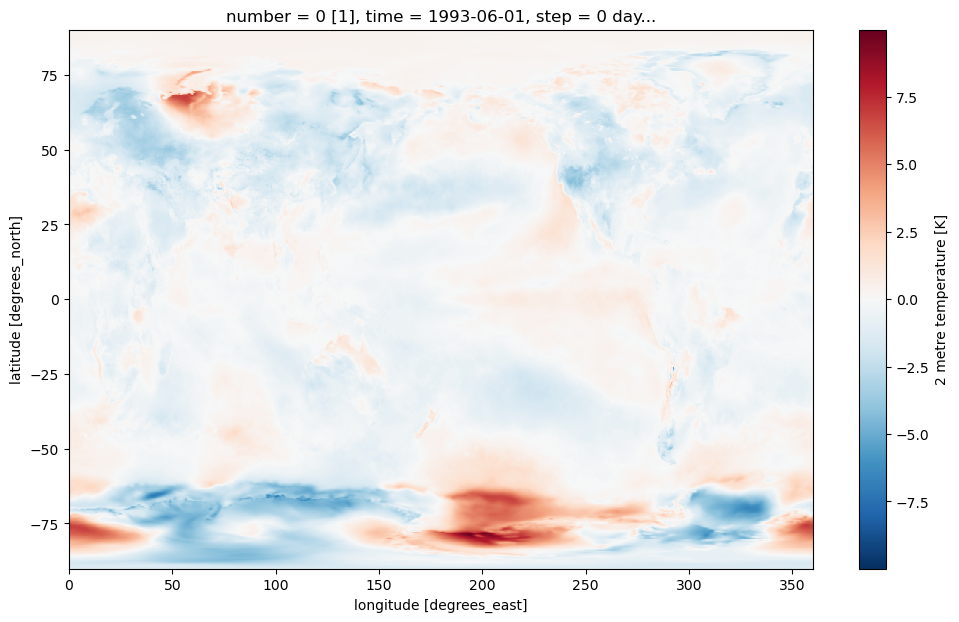

In [5]:
import matplotlib.pyplot as plt

# plot data variable for year 1993
df_93['t2m'].plot(figsize=(12, 7))
plt.show()

### 2. Calculating Extent With Fixed Ratio

We will create a function that returns a map extent for a 16:9 ratio, inspired by a similar [solution](https://medium.com/@lubomirfranko/create-custom-cartopy-map-extent-having-always-16-9-ratio-climate-data-visualisation-with-python-4e765a9f08be). This allows us to keep a neat and fixed shape of the basemap to fit into a report’s layout. Different projections have different units for longitude and latitude. For the default Plate carrée projection we need these units in degrees and for the Mercator we need meters. As a standard, we usually work with a geographic coordinate system (GCS) which is pretty much identical to Plate carrée and also uses degrees. No point transformations between coordinate systems are needed in our case.

We will start by calculating the longitude distance, the distance between extreme longitude coordinates. The minimum and maximum longitudes can be found by multiplying a chosen zoom coefficient $k_{coef}$ of the map by a zoom level $k_{level}$ and adding/subtracting these values to the longitude of a center point:

$$D_\lambda = \lambda_{max} - \lambda_{min} = (P_\lambda + k_{coef} \times k_{level}) - (P_\lambda - k_{coef} \times k_{level}).$$

Since this projection is spherical and we want the smaller aspect of the ratio to be vertical (latitude), we can calculate the latitude distance from this formula: 

$$\frac{D_\lambda}{D_\phi} = \frac{16}{9},$$
and after a few transformations we get:

$$D_\phi = {D_\lambda} \times \frac{9}{16}.$$

Then we take half of the distance $D_{\Phi}$ and add/subtract to the latitude of our center point. For the area of interest for this notebook, we will choose a random point over Bangladesh: 20°N, 90°E.

In [6]:
# get extent from central location and zoom level in original CRS
def generate_extent(center_point, zoom, aspect_ratio):
    # define zoom scaling
    zoom_coefficient = 2
    
    # calculate minimum longitude (long_min) and maximnum longitude (long_max)
    long_min, long_max = (center_point[0] - (zoom_coefficient * zoom), center_point[0] + (zoom_coefficient * zoom))

    # calculate distance between min_long and max_long
    long_distance = (long_max) - (long_min)
        
    # calculate latitude distance
    lat_distance = long_distance * aspect_ratio[1] / aspect_ratio[0]
        
    # calculate max_lat and min_lan by adding/subtracting half of the distance from center latitude
    lat_max = center_point[1] + lat_distance/2
    lat_min = center_point[1] - lat_distance/2

    return [long_min, long_max, lat_min, lat_max]

# center_point = (long, lat)
# aspect_ratio = (width, height)
map_extent = generate_extent(center_point=(90, 20), zoom=21, aspect_ratio=(16, 9))
map_extent

[48, 132, -3.625, 43.625]

### 3. Plotting Function

This will be the main function for generating our basemaps. We will define and customize all features, gridlines, labels, and colorbar.

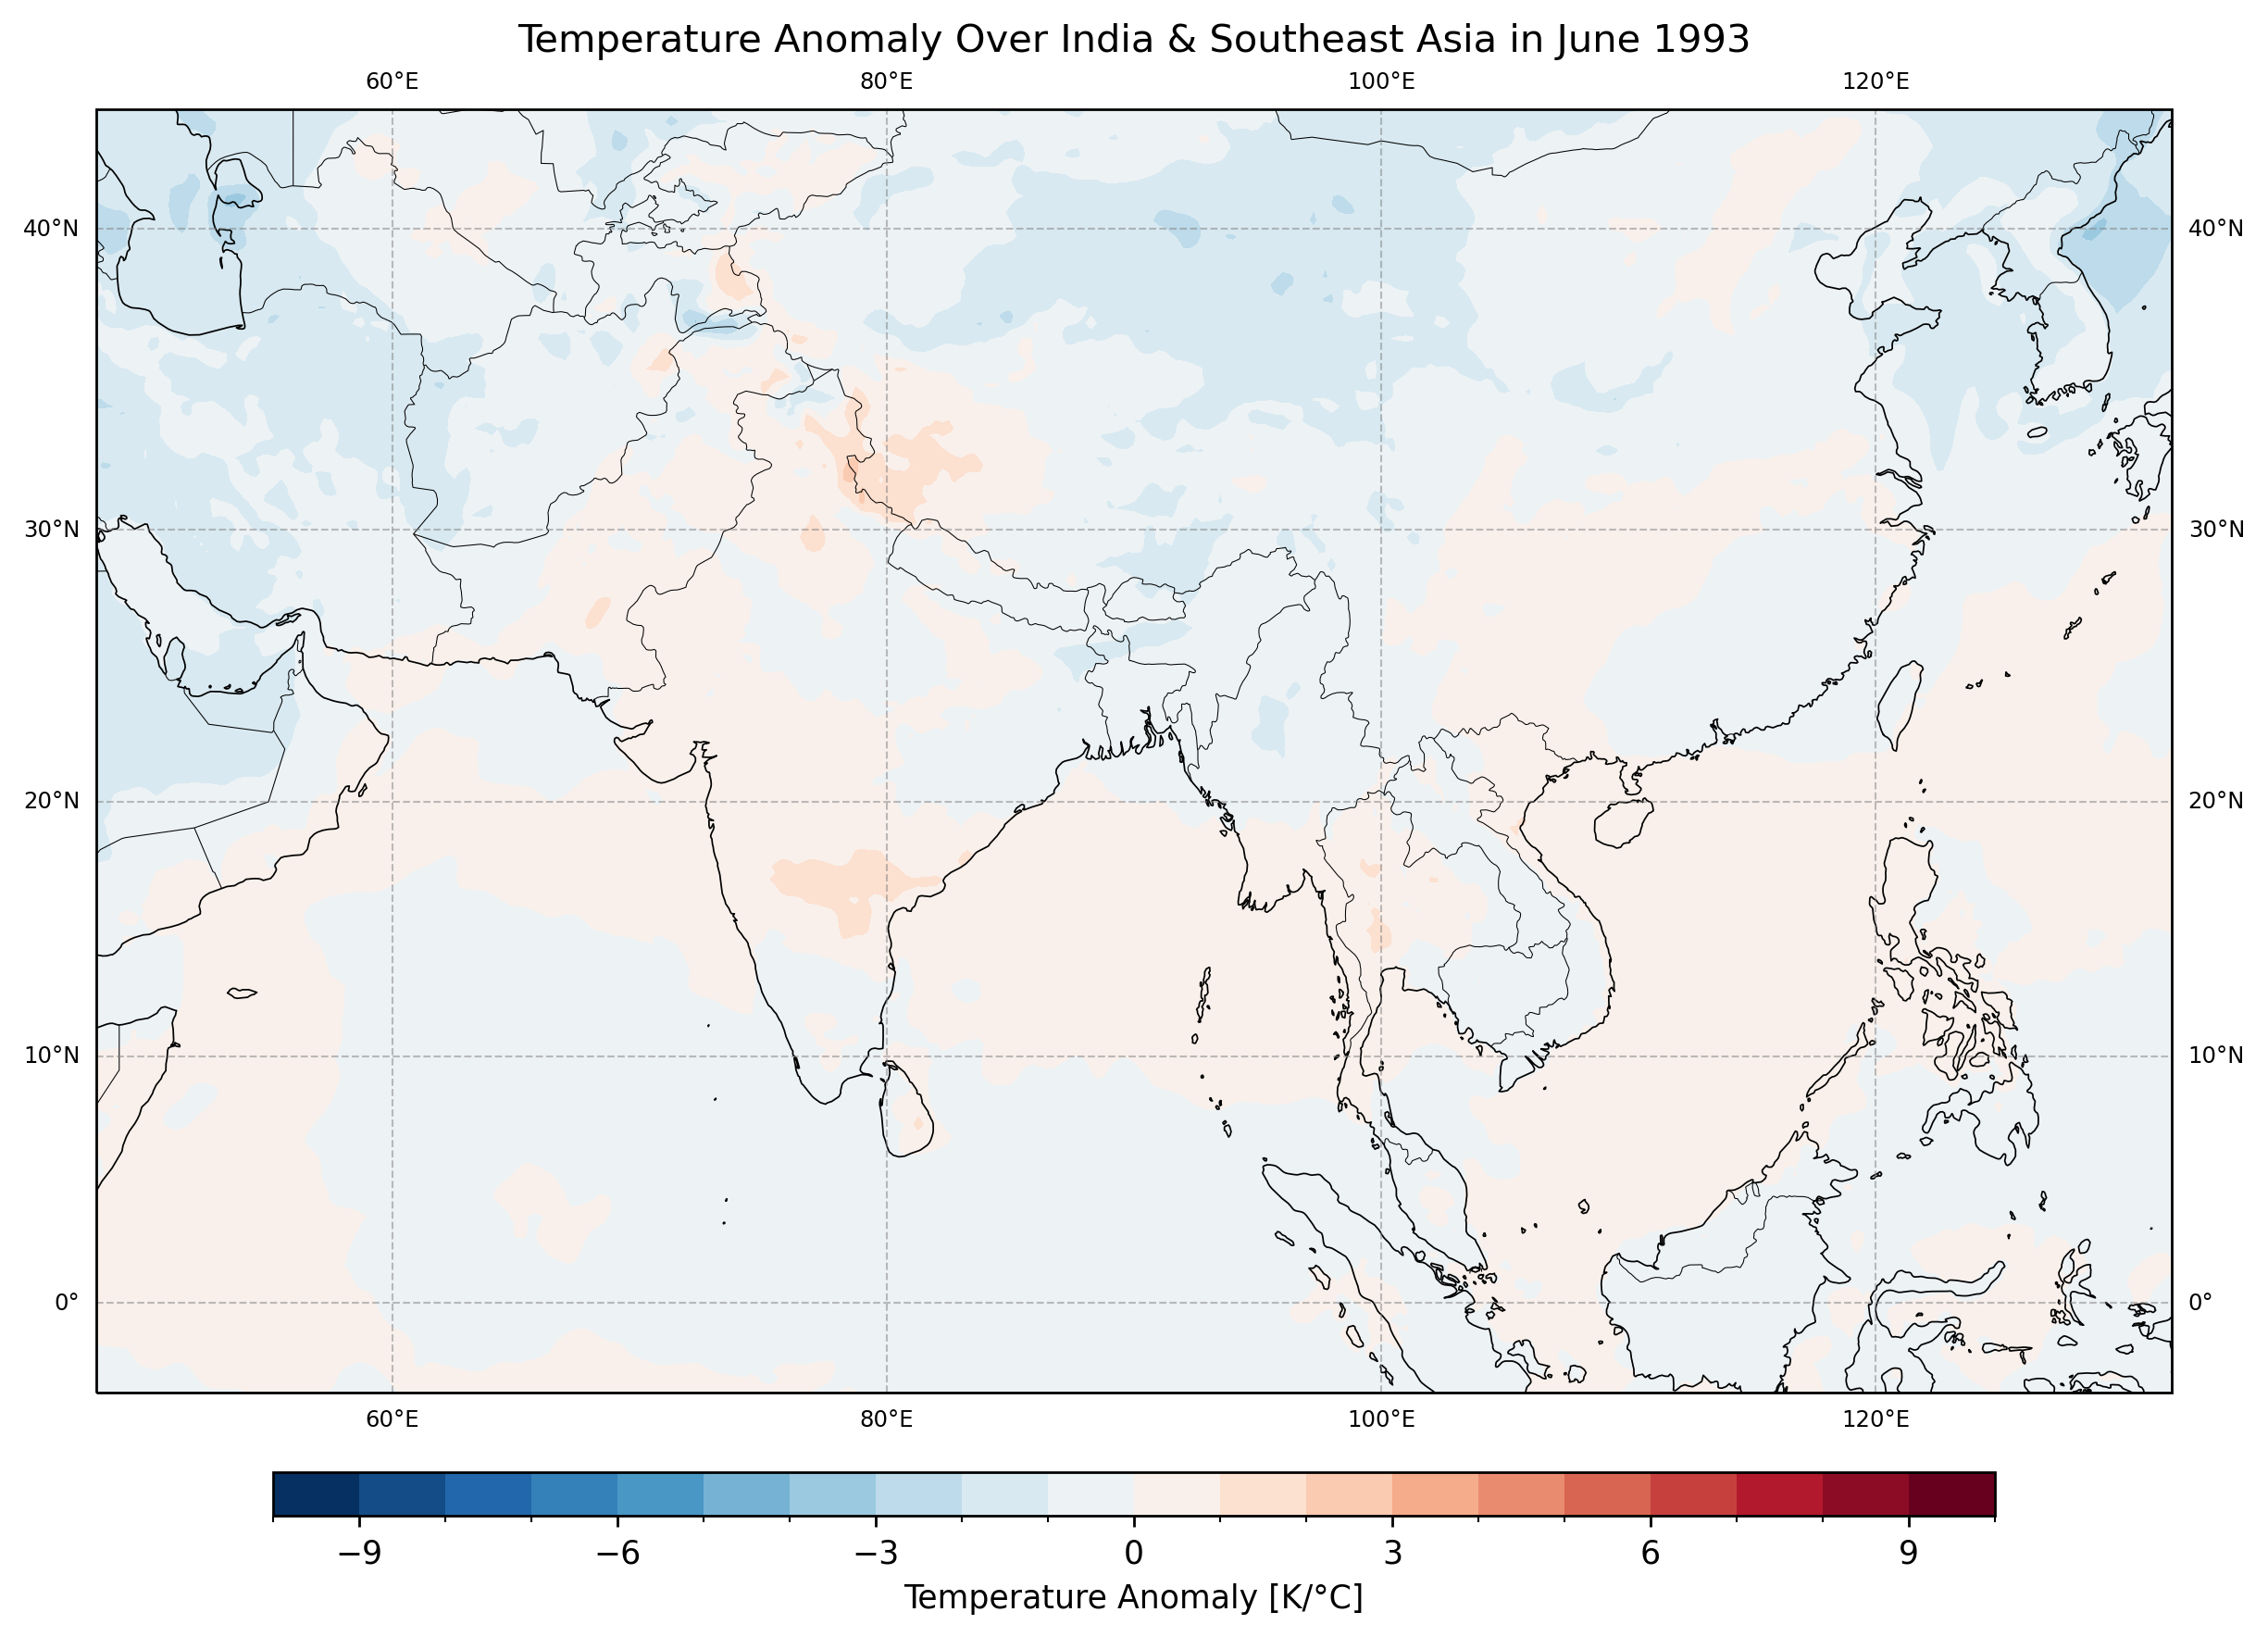

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# general plotting function
def plot_map(dataset, extent, title_text):
    plt.figure(figsize=(16, 9), dpi=250)
    ax = plt.axes(projection=ccrs.Mercator(), frameon=True)
    
    # add gridlines in degrees over Mercator map
    gl = ax.gridlines(draw_labels=True, linewidth=0.6, crs=ccrs.PlateCarree(), color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 7, 'color': 'black'}
    gl.ylabel_style = {'size': 7, 'color': 'black'}
    
    # colorbar dictionary
    cbar_kwargs = {'orientation': 'horizontal', 'pad': 0.05, 'aspect': 40, 'shrink': 0.6,
                   'label': 'Temperature Anomaly [K/\u00b0C]'}
    
    # add map features
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), lw=0.3)

    # basemap
    dataset['t2m'].plot.contourf(ax=ax, cbar_kwargs=cbar_kwargs, levels=21, transform=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # add title
    plt.title(title_text.format(dataset.valid_time.dt.strftime('%B %Y').values))
    plt.show()

# extent = [long_min, long_max, lat_min, lat_max]
plot_map(dataset=df_93, extent=map_extent, title_text='Temperature Anomaly Over India & Southeast Asia in {}')

### 4. Adjusting Longitude Coordinates

The final maps are almost ready to plot. Most projections are defined with longitude range -180 to 180 degrees and our GRIB file contains coordinates in 0 to 360. To avoid mapping errors and white vertical lines, we will convert them to the proper range and add a cyclic point from <code>cartopy</code> just in case to wrap our dataset around. To speed up and optimize the process, we will slice the xarray data into our chosen extent.

In [8]:
# convert longitude coordinates from range (0, 360) to (-180, 180)
def adjust_longitude(dataset):
    # adjust longitude values to make sure they are within (-180, 180)
    dataset['longitude_fixed'] = xr.where(dataset['longitude'] > 180, dataset['longitude'] - 360, dataset['longitude'])
        
    dataset = (dataset.swap_dims({'longitude': 'longitude_fixed'})
               .sel(**{'longitude_fixed': sorted(dataset.longitude_fixed)}).drop('longitude'))

    dataset = dataset.rename({'longitude_fixed': 'longitude'})
    return dataset

### 5. Combining All Functions and Performing Final Basemaps

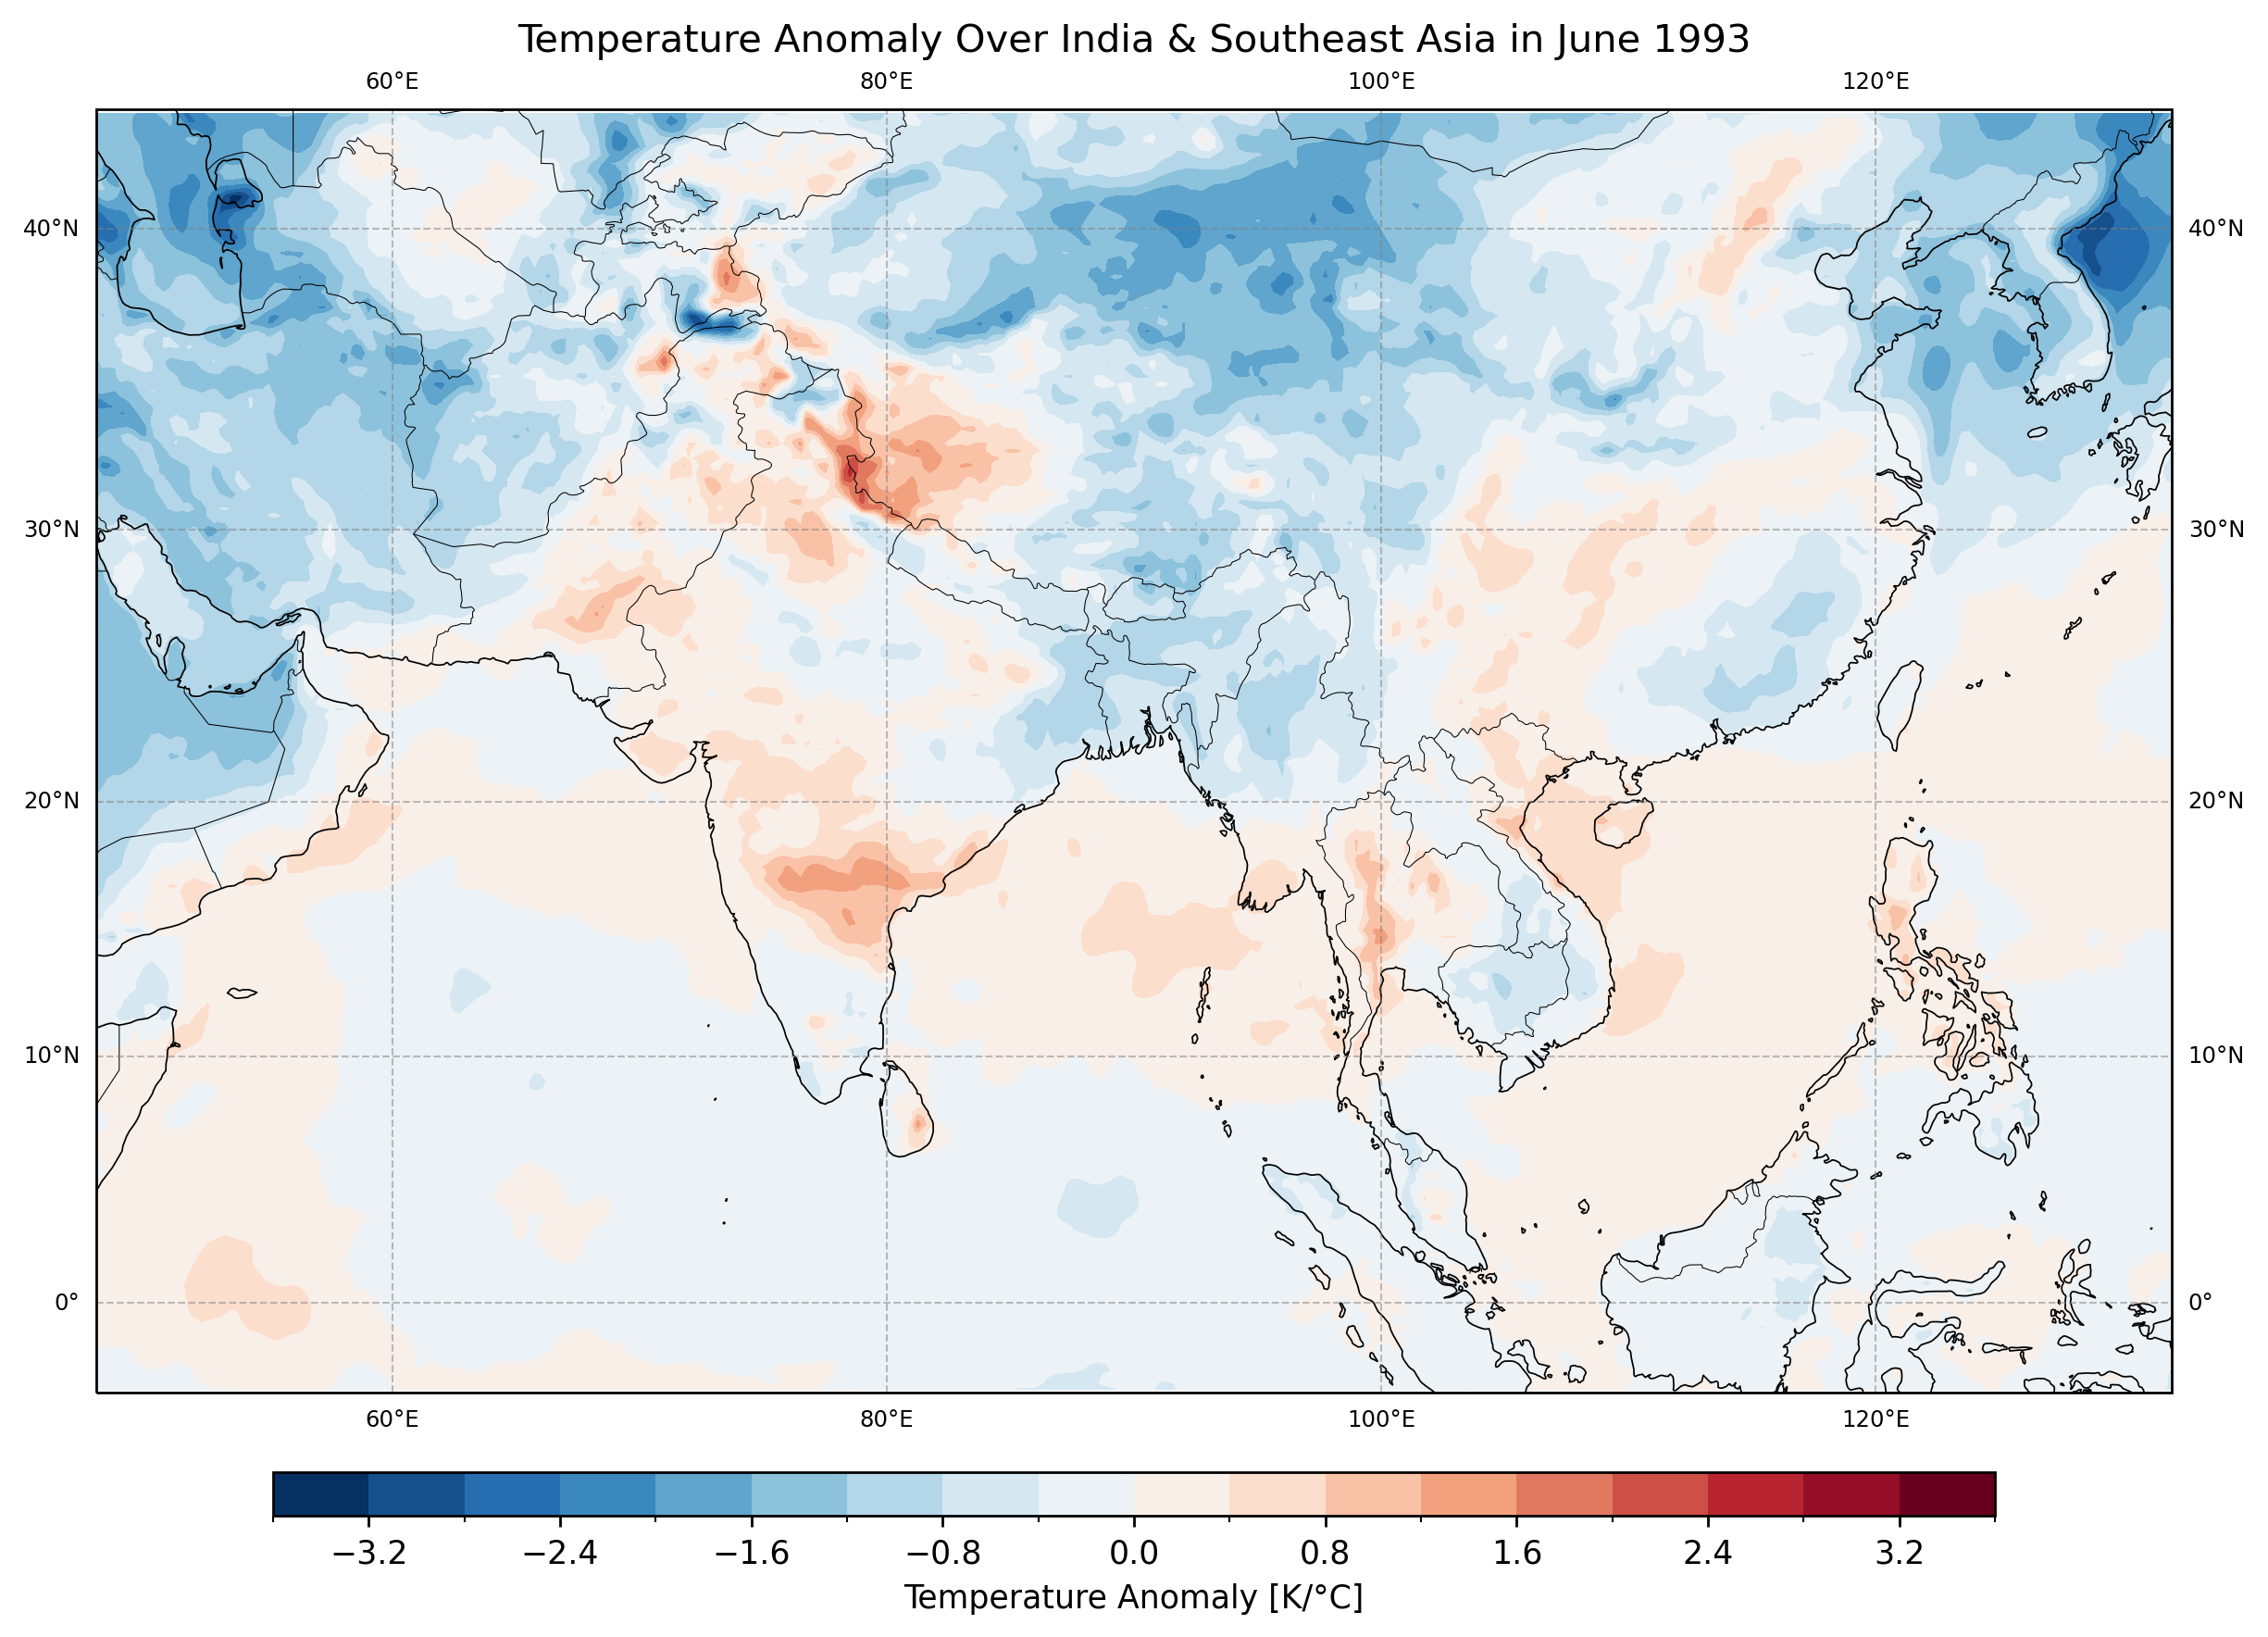

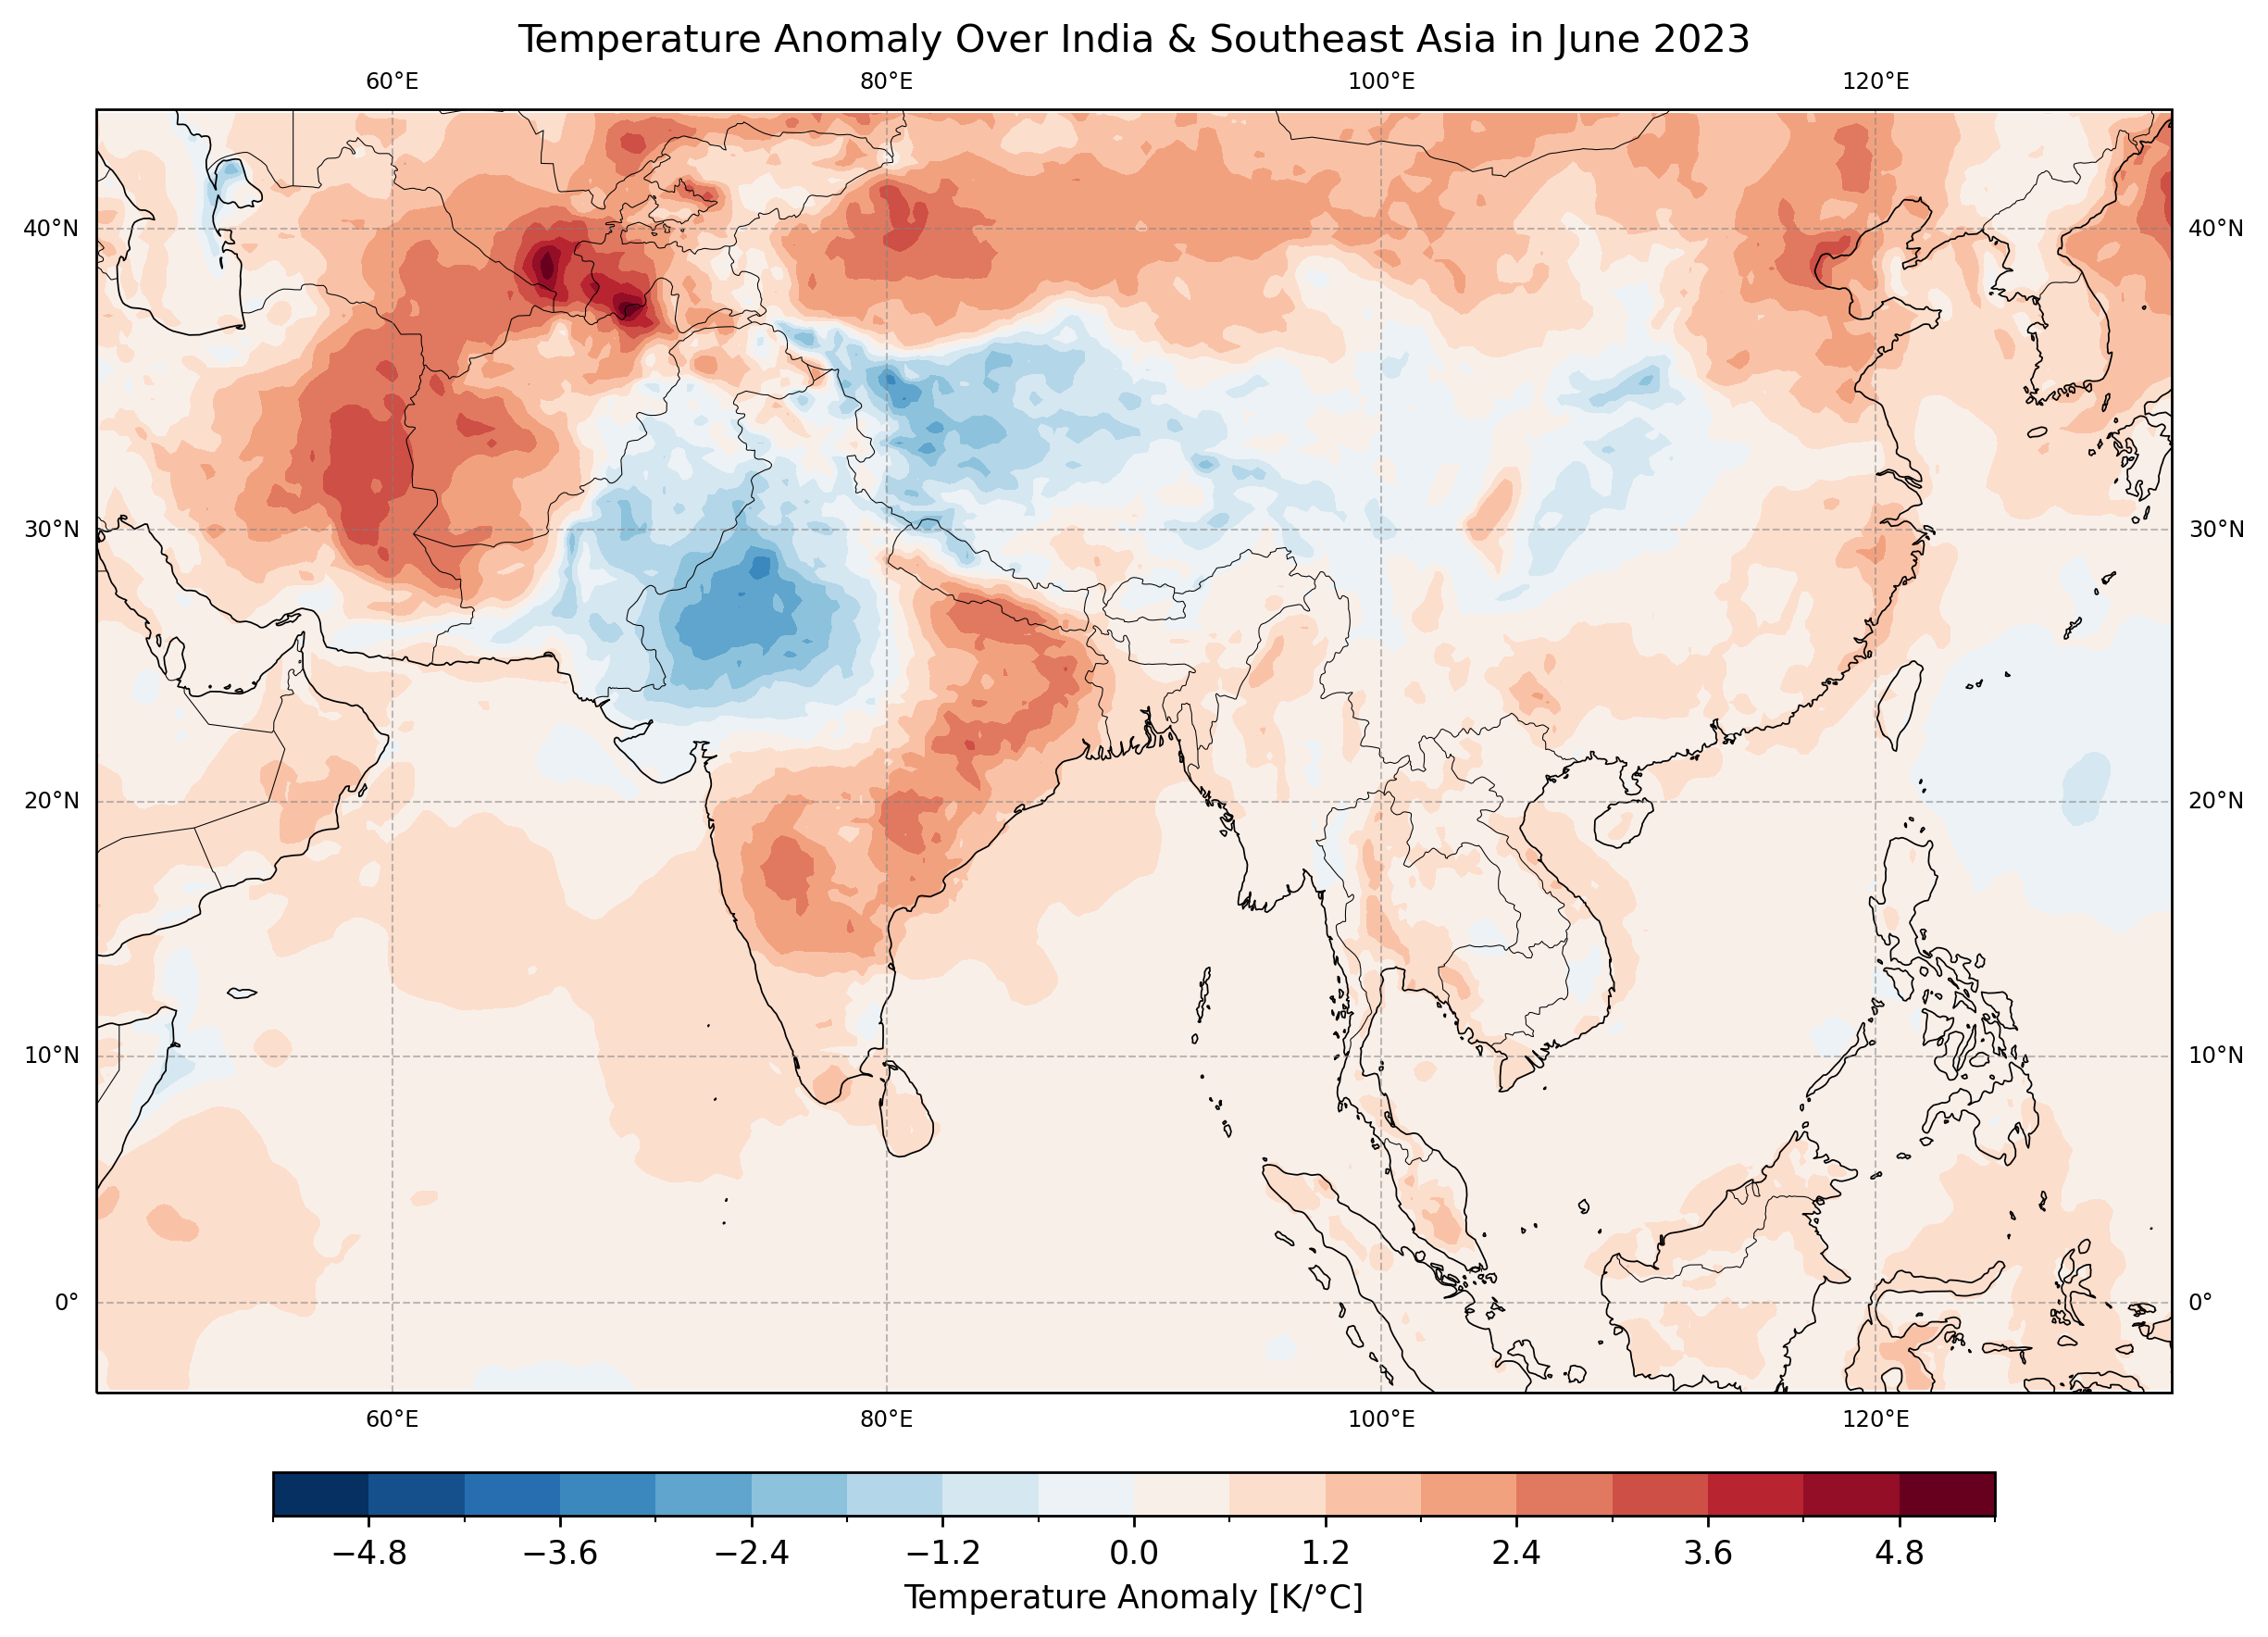

In [9]:
# combine all functions for final visualizations
# extract boundary coordinates from extent
long_min = map_extent[0]
long_max = map_extent[1]
lat_min = map_extent[2]
lat_max = map_extent[3]

from copy import deepcopy
from cartopy.util import add_cyclic_point

# loop through xarray datasets
for i in [df_93, df_23]:
    # create a deep copy of the data so we maintain original data
    df_copy = deepcopy(i)
    
    # apply longitude conversion
    df_copy = adjust_longitude(df_copy)
    
    # crop data to extent coordinates
    df_copy = df_copy.sel(latitude=slice(lat_max, lat_min), longitude=slice(long_min, long_max))
    
    # display contour map
    plot_map(dataset=df_copy, extent=map_extent, title_text='Temperature Anomaly Over India & Southeast Asia in {}')

Comparing these two charts clearly shows significant temperature changes within the last 30 years. The anomalies are much higher for the lastest data from June 2023 with 1.8 K/°C differences for extreme values. The most endangered locations are the East Coast of India, East Iran, and the Uzbekistan-Tajikistan regions. The maps display that climate change is undeniable and is becoming a serious issue for Earth.

### 6. Conclusions

This notebook demonstrated an easy way to visualize climate changes using grid data distributed as GRIB files. The data has been collected using an API from the official Copernicus website. Using two geospatial libraries: <code>xarray</code> and <code>cartopy</code>, we visualised temperature anomalies quickly and efficiently. The final outputs of this notebook are two plots with a 30 year timespan mapped over a chosen area in Asia. The maps proved that we are facing rapid climate change.

### 7. Bonus: Plotting Temperature Anomaly Over Antarctica

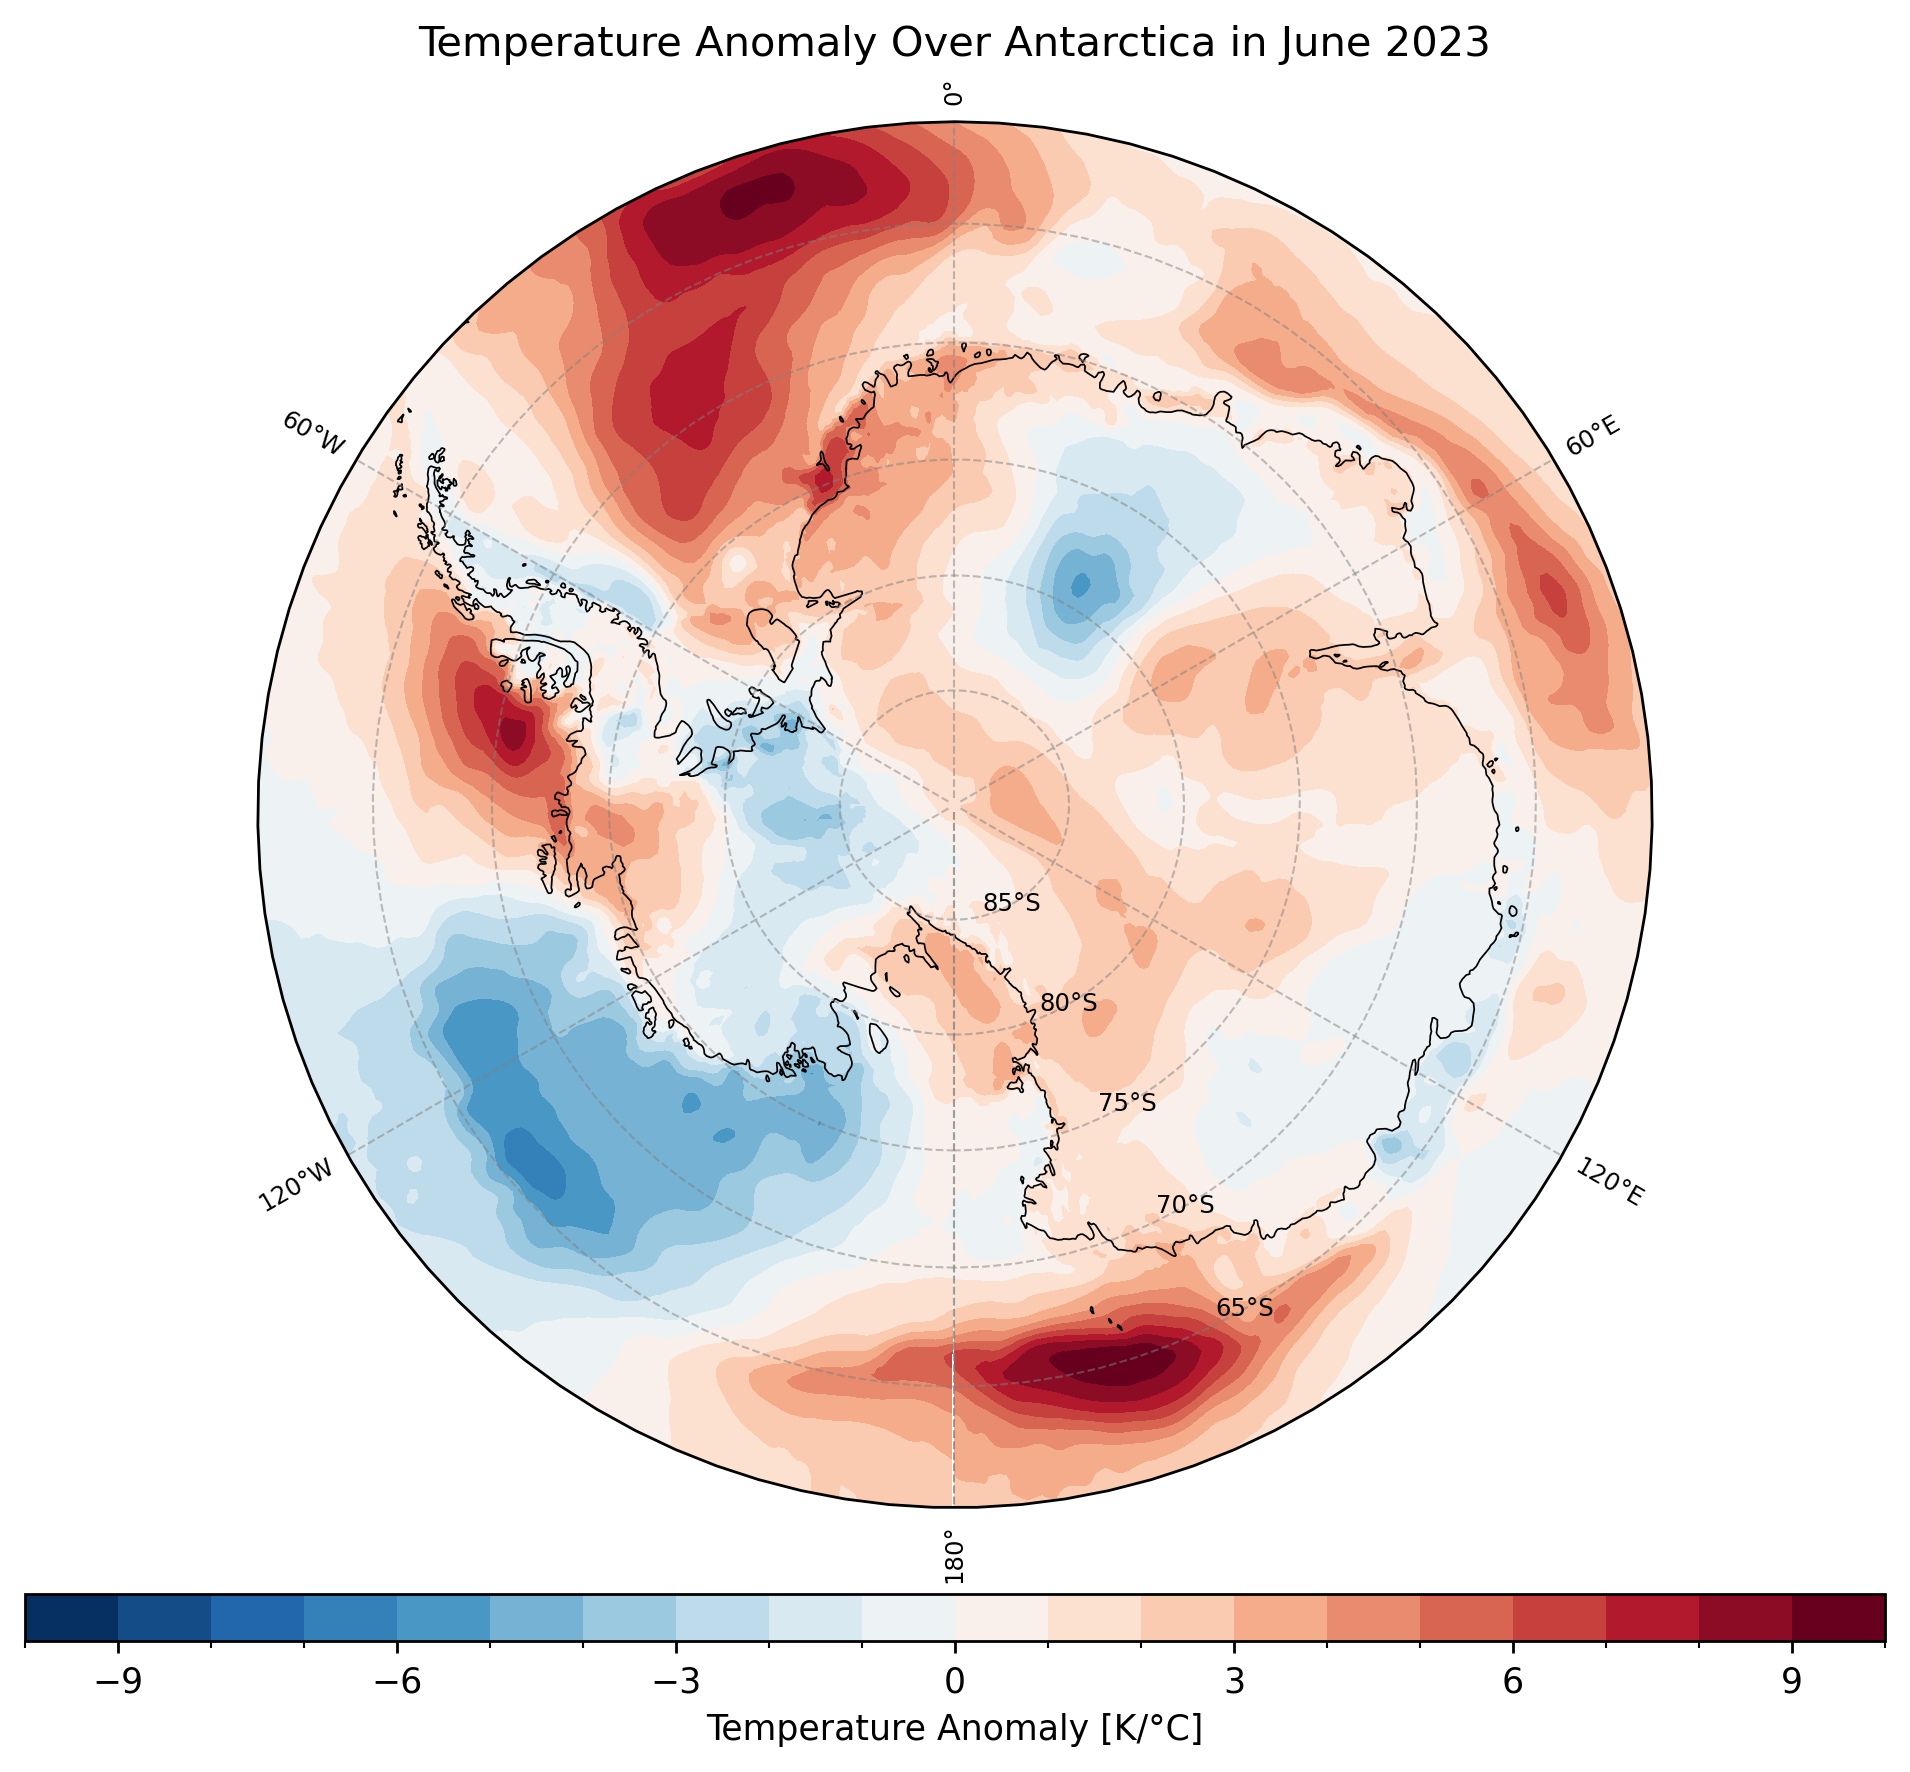

In [10]:
df_copy = deepcopy(df_23)
df_copy = adjust_longitude(df_copy)
df_copy = df_copy.sel(latitude=slice(-60, -90), longitude=slice(-180, 180))

def plot_antarctica(dataset):
    plt.figure(figsize=(16, 9), dpi=250)
    ax = plt.axes(projection=ccrs.SouthPolarStereo(), frameon=True)
    
    # add gridlines in degrees over Mercator map
    gl = ax.gridlines(draw_labels=True, linewidth=0.6, crs=ccrs.PlateCarree(), color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 7, 'color': 'black'}
    gl.ylabel_style = {'size': 7, 'color': 'black'}
    
    # colorbar dictionary
    cbar_kwargs = {'orientation': 'horizontal', 'pad': 0.05, 'aspect': 40, 'shrink': 0.6,
                   'label': 'Temperature Anomaly [K/\u00b0C]'}
    
    # add map features
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), lw=0.3)
    
    import matplotlib.path as mpath
    from numpy import linspace, vstack, sin, cos, pi

    # compute circular boundaries
    theta = linspace(0, 2*pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = vstack([sin(theta), cos(theta)]).T
    circle = mpath.Path(verts*radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)

    # basemap
    dataset['t2m'].plot.contourf(ax=ax, cbar_kwargs=cbar_kwargs, levels=21, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
    
    # add title
    plt.title('Temperature Anomaly Over Antarctica in {}'.format(dataset.valid_time.dt.strftime('%B %Y').values))
    plt.show()

plot_antarctica(dataset=df_copy)